**You may need to install [OpenCV](https://pypi.python.org/pypi/opencv-python) and [scikit-video](http://www.scikit-video.org/stable/).**

In [39]:
import keras
import numpy as np
import io
import base64
from IPython.display import HTML
import skvideo
skvideo.setFFmpegPath('/anaconda/bin')
import skvideo.io
import cv2
from IPython.display import YouTubeVideo
import json

from keras.models import Sequential,model_from_json
from keras.layers.core import Dense
from keras.optimizers import sgd
from keras.layers import Conv2D, MaxPooling2D, Activation, AveragePooling2D,Reshape,BatchNormalization, Dropout, Flatten
from keras.utils import np_utils

# MiniProject #3: Deep Reinforcement Learning

__Notations__: $E_p$ is the expectation under probability $p$. Please justify each of your answer and widely comment your code.

# Context

In a reinforcement learning algorithm, we modelize each step $t$ as an action $a_t$ obtained from a state $s_t$, i.e. $\{(a_{t},s_{t})_{t\leq T}\}$ having the Markov property. We consider a discount factor $\gamma \in [0,1]$ that ensures convergence. The goal is to find among all the policies $\pi$, one that maximizes the expected reward:

\begin{equation*}
R(\pi)=\sum_{t\leq T}E_{p^{\pi}}[\gamma^t r(s_{t},a_{t})] \> ,
\end{equation*}

where: 
\begin{equation*}p^{\pi}(a_{0},a_{1},s_{1},...,a_{T},s_{T})=p(a_{0})\prod_{t=1}^{T}\pi(a_{t}|s_{t})p(s_{t+1}|s_{t},a_{t}) \> .
\end{equation*}

We note the $Q$-function:

\begin{equation*}Q^\pi(s,a)=E_{p^{\pi}}[\sum_{t\leq T}\gamma^{t}r(s_{t},a_{t})|s_{0}=s,a_{0}=a] \> .
\end{equation*}

Thus, the optimal Q function is:
\begin{equation*}
Q^*(s,a)=\max_{\pi}Q^\pi(s,a) \> .
\end{equation*}

In this project, we will apply the deep reinforcement learning techniques to a simple game: an agent will have to learn from scratch a policy that will permit it maximizing a reward.

## The environment, the agent and the game

### The environment

```Environment``` is an abstract class that represents the states, rewards, and actions to obtain the new state.

In [40]:
class Environment(object):
    def __init__(self):
        pass

    def act(self, act):
        """
        One can act on the environment and obtain its reaction:
        - the new state
        - the reward of the new state
        - should we continue the game?

        :return: state, reward, game_over
        """
        pass


    def reset(self):
        """
        Reinitialize the environment to a random state and returns
        the original state

        :return: state
        """
        pass
    
    def draw(self):
        """
        Visualize in the console or graphically the current state
        """
        pass

The method ```act``` allows to act on the environment at a given state $s_t$ (stored internally), via action $a_t$. The method will return the new state $s_{t+1}$, the reward $r(s_{t},a_{t})$ and determines if $t\leq T$ (*game_over*).

The method ```reset``` simply reinitializes the environment to a random state $s_0$.

The method ```draw``` displays the current state $s_t$ (this is useful to check the behavior of the Agent).

We modelize $s_t$ as a tensor, while $a_t$ is an integer.

### The Agent

The goal of the ```Agent``` is to interact with the ```Environment``` by proposing actions $a_t$ obtained from a given state $s_t$ to attempt to maximize its __reward__ $r(s_t,a_t)$. We propose the following abstract class:

In [41]:
class Agent(object):
    def __init__(self, epsilon=0.1, n_action=4):
        self.epsilon = epsilon
        self.n_action = n_action
    
    def set_epsilon(self,e):
        self.epsilon = e

    def act(self,s,train=True):
        """ This function should return the next action to do:
        an integer between 0 and 4 (not included) with a random exploration of epsilon"""
        if train:
            if np.random.rand() <= self.epsilon:
                a = np.random.randint(0, self.n_action, size=1)[0]
            else:
                a = self.learned_act(s)
        else: # in some cases, this can improve the performance.. remove it if poor performances
            a = self.learned_act(s)
        return a

    def learned_act(self,s):
        """ Act via the policy of the agent, from a given state s
        it proposes an action a"""
        pass

    def reinforce(self, s, n_s, a, r, game_over_):
        """ This function is the core of the learning algorithm. 
        It takes as an input the current state s_, the next state n_s_
        the action a_ used to move from s_ to n_s_ and the reward r_.
        
        Its goal is to learn a policy.
        """
        pass

    def save(self):
        """ This function returns basic stats if applicable: the
        loss and/or the model"""
        pass

    def load(self):
        """ This function allows to restore a model"""
        pass

***
__Question 1__:
Explain the function act. Why is ```epsilon``` essential?

<font color='blue'>

> $\epsilon$ represents a trade-off between exploration and exploitation of the environnement. While a low espsilon will tend to let the agent select a policy already visited and known to be of high reward (this behaviour is refered as exploitation), a high epsilon will let him take randomly new actions and states and explore there reward signals (exploration).

***
### The Game

The ```Agent``` and the ```Environment``` work in an interlaced way as in the following (take some time to understand this code as it is the core of the project)

```python

epoch = 300
env = Environment()
agent = Agent()


# Number of won games
score = 0
loss = 0


for e in range(epoch):
    # At each epoch, we restart to a fresh game and get the initial state
    state = env.reset()
    # This assumes that the games will end
    game_over = False

    win = 0
    lose = 0
    
    while not game_over:
        # The agent performs an action
        action = agent.act(state)

        # Apply an action to the environment, get the next state, the reward
        # and if the games end
        prev_state = state
        state, reward, game_over = env.act(action)

        # Update the counters
        if reward > 0:
            win = win + reward
        if reward < 0:
            lose = lose -reward

        # Apply the reinforcement strategy
        loss = agent.reinforce(prev_state, state,  action, reward, game_over)

    # Save as a mp4
    if e % 10 == 0:
        env.draw(e)

    # Update stats
    score += win-lose

    print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
          .format(e, epoch, loss, win, lose, win-lose))
    agent.save()
```

# The game, *eat cheese*

A rat runs on an island and tries to eat as much as possible. The island is subdivided into $N\times N$ cells, in which there are cheese (+0.5) and poisonous cells (-1). The rat has a visibility of 2 cells (thus it can see $5^2$ cells). The rat is given a time $T$ to accumulate as much food as possible. It can perform 4 actions: going up, down, left, right. 

The goal is to code an agent to solve this task that will learn by trial and error. We propose the following environment:

In [43]:
class Environment(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))

        # coordinate of the cat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board<0,2] = 256
        b[self.x,self.y,:] = 256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""

        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[:,-2:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        reward = self.board[self.x, self.y]
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]


        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))

        malus[bonus>0]=0

        self.board = bonus + malus

        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:, :] = -1
        self.position[-2:, :] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.board.reshape(self.grid_size, self.grid_size,1),
                        self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

The following elements are important because they correspond to the hyper parameters for this project:

In [44]:
# parameters
size = 20
T=50
temperature=0.2
epochs_train=10 # set small when debugging
epochs_test=10 # set small when debugging

# display videos
def display_videos(name):
    video = io.open(name, 'r+b').read()
    encoded = base64.b64encode(video)
    return '''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))

__Question 2__ Explain the use of the arrays ```position``` and ```board```.

> The arrays "position" and "board" are 2 attributes of the class Environnment that stores the informations about the grid/map on whihc the game is payed. The board namely stores the rewards signals the agent gets when it reach this location. The position array stores the location of the agent on the map during the game.

## Random Agent

***
__Question 3__ Implement a random Agent (only ```learned_act``` needs to be implemented):

In [45]:
class RandomAgent(Agent):
    def __init__(self):
        super(RandomAgent, self).__init__()
        pass

    def learned_act(self, s):
        action = np.random.randint(0,4)
        return action

***
***
__Question 4__ Visualize the game moves. You need to fill in the following function for the evaluation:

In [46]:
def test(agent,env,epochs,prefix=''):
    # Number of won games
    score = 0
        
    for e in range(epochs):
        
        state = env.reset()
        game_over = False
        win = 0
        lose = 0        

        while game_over == False:
            
            #play and interact
            action = agent.learned_act(state)
            state, reward, game_over = env.act(action)
            
            #update score
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose - reward
                
            # Save as a mp4
            env.draw(prefix+str(e))
            
            #if re > 0:
            #    win = win + re
            #if re < 0:
            #    lose = lose - re
        # Update stats
        #score = score + win-lose
        score = score + win-lose
        print("Win/lose count {}/{}. Average score ({})".format(win, lose, score/(1+e)))
    print('Final score: '+str(score/epochs))

In [68]:
# Initialize the game
env = Environment(grid_size=size, max_time=T,temperature=temperature)

# Initialize the agent!
agent = RandomAgent()
test(agent,env,epochs_test,prefix='random')


Win/lose count 5.0/8.0. Average score (-3.0)
Win/lose count 4.5/8.0. Average score (-3.25)
Win/lose count 4.5/11.0. Average score (-4.333333333333333)
Win/lose count 4.5/7.0. Average score (-3.875)
Win/lose count 2.5/5.0. Average score (-3.6)
Win/lose count 5.0/13.0. Average score (-4.333333333333333)
Win/lose count 8.0/7.0. Average score (-3.5714285714285716)
Win/lose count 4.5/8.0. Average score (-3.5625)
Win/lose count 7.0/10.0. Average score (-3.5)
Win/lose count 7.5/13.0. Average score (-3.7)
Final score: -3.7


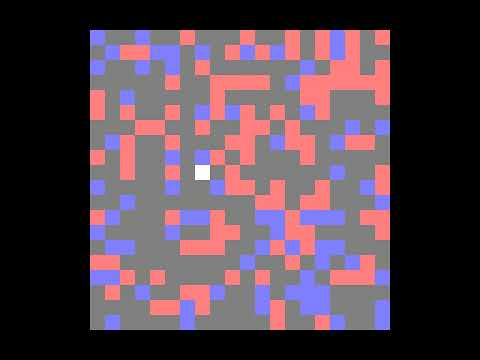

In [67]:
YouTubeVideo('So3rvTzC29g',width=600, height=600)

***
## DQN

Let us assume here that $T=\infty$.

***
__Question 5__ Let $\pi$ be a policy, show that:

\begin{equation*}
Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]
\end{equation*}

Then, show that for the optimal policy $\pi^*$ (we assume its existence), the following holds: 

\begin{equation*}
Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].
\end{equation*}
Finally, deduce that a plausible objective is:

\begin{equation*}
\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.
\end{equation*}




1 -  $Q^{\pi}(s,a)=E_{(s',a')\sim p(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]$}

<font color='blue'>

> $Q^{\pi}(s,a) = E_{p^{\pi}}[\sum\limits_{t = 0}^{\infty}\gamma^{t}r(s_{t},a_{t})\|s_0=s,a_0=a]$

>$Q^{\pi}(s,a) =E_{p^{\pi}}[r(s,a) + \gamma E_{p^{\pi}}[\sum\limits_{t = 1}^{\infty}\gamma^{t-1}r(s_{t},a_{t})|s_1=s',a_1=a']|s_0=s,a_0=a]$ 

>$Q^{\pi}(s,a)=E_{(s',a')\sim p^{\pi}(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]$

2 - Bellman equation reritting

<font color='blue'>
 

> Let us define $\pi$ the greedy policy w.r.t $\pi^{*}$ the optimal policy. Then we have by applying the first equlity to $\pi$

>$Q^{\pi}(s,a)=E_{(s',a')\sim p^{\pi^{*}}(.|s,a)}[r(s,a)+\gamma Q^{\pi}(s',a')]$

>$Q^{\pi}(s,a)= r(s,a) + \gamma\sum\limits_{s'\in S}p(s'|s,a)\pi(a'|s')Q^{\pi}(s',a')$ and since $\pi$ is greedy policy we have: $\pi(a'|s')$ is the dirac function for $a' = argmax_{a'} Q^{\pi^{*}}(s',a')$ so the q fucntion can be rewritten as:

> $Q^{\pi}(s,a)= E_{s'\sim \pi(.|s,a)}[r(s,a)+\gamma max_{a'}Q^{\pi}(s',a')]$

> But since $\pi*$ is optimal, a greedy policy of that policy is the optimal policy itself, hence $\pi = \pi^{*}$

> Finally, $Q^{*}(s,a)=E_{s'\sim \pi^*(.|s,a)}[r(s,a)+\gamma\max_{a'}Q^{*}(s',a')].$


> This result shows that knowing the optimal q state-action value-fucntion is equivalent to know the optimal policy function since any greedy policy w.r.t to that value function is optimal.

3 - Objective function
<font color='blue'>
 

> Since we want the network to learn the optimal action policy value function for the Markovian sequence, a logical objective is to make the action policy function of the network veryfing the Bellman optimality equation (2). Thus we minimize the average square error between the values predicted by the network and the target output for each actions, given that the optimal value function verifies the equation 2. 

> $\mathcal{L}(\theta)=E_{s' \sim \pi^*(.|s,a)}\Vert r+\gamma\max_{a'}Q(s',a',\theta)-Q(s,a,\theta)\Vert^{2}.$



***
The DQN-learning algorithm relies on these derivations to train the parameters $\theta$ of a Deep Neural Network:

1. At the state $s_t$, select the action $a_t$ with best reward using $Q_t$ and store the results;

2. Obtain the new state $s_{t+1}$ from the environment $p$;

3. Store $(s_t,a_t,s_{t+1})$;

4. Obtain $Q_{t+1}$ by minimizing  $\mathcal{L}$ from a recovered batch from the previously stored results.

***
__Question 6__ Implement the class ```Memory``` that stores moves (in a replay buffer) via ```remember``` and provides a ```random_access``` to these. Specify a maximum memory size to avoid side effects. You can for example use a ```list()``` and set by default ```max_memory=100```.

In [48]:
class Memory(object):
    def __init__(self, max_memory=100):
        self.max_memory = max_memory
        self.memory = list()

    def remember(self, m):
        if len(self.memory)>=self.max_memory:
            self.memory[np.random.randint(self.max_memory)]= m
        else:
            self.memory.append(m)

    def random_access(self):
        return self.memory[np.random.randint(len(self.memory))]

***
The pipeline we will use for training is given below:

In [49]:
def train(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    loss_ = []

    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            action = agent.act(state)

            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = win + reward
            if reward < 0:
                lose = lose -reward

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state,  action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += win-lose

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
        loss_.append(loss)
    return loss_

***
__Question 7__ Implement the DQN training algorithm using a cascade of fully connected layers. You can use different learning rate, batch size or memory size parameters. In particular, the loss might oscillate while the player will start to win the games. You have to find a good criterium.

In [50]:
class DQN(Agent):
    def __init__(self, grid_size,  epsilon = 0.1, memory_size=100, batch_size = 16,n_state=2):
        super(DQN, self).__init__(epsilon = epsilon)

        # Discount for Q learning
        self.discount = 0.99
        
        self.grid_size = grid_size
        
        # number of state
        self.n_state = n_state

        # Memory
        self.memory = Memory(memory_size)
        
        # Batch size when learning
        self.batch_size = batch_size

    def learned_act(self, s):
        pass

    def reinforce(self, s_, n_s_, a_, r_, game_over_):
        # Two steps: first memorize the states, second learn from the pool
        
        #Q-Learning with experience replay implementation

        self.memory.remember([s_, n_s_, a_, r_, game_over_])
        
        input_states = np.zeros((self.batch_size,5,5,self.n_state))
        target_q = np.zeros((self.batch_size, 4))
        
        for i in range(self.batch_size):
            
            batch = self.memory.random_access() #randomly selecting episodes
            
            if batch[4]: #game_over
                input_states[i] = batch[0]
                target_q[i,:] = self.model.predict(batch[0].reshape((1,5,5,self.n_state)))
                target_q[i,int(batch[2])] = batch[3]
            else:
                input_states[i] = batch[0]
                target_q[i,:] = self.model.predict(batch[0].reshape((1,5,5,self.n_state)))
                target_q[i,int(batch[2])] = batch[3] + self.discount*np.max(self.model.predict(batch[1].reshape((1,5,5,self.n_state))))
        
        # HINT: Clip the target to avoid exploiding gradients.. -- clipping is a bit tighter
        #NB this is made useless by the squashing operation
        target_q = np.clip(target_q, -8, 8)
        l = self.model.train_on_batch(input_states, target_q)

        return l

    def save(self,name_weights='model.h5',name_model='model.json'):
        self.model.save_weights(name_weights, overwrite=True)
        with open(name_model, "w") as outfile:
            json.dump(self.model.to_json(), outfile)
            
    def load(self,name_weights='model.h5',name_model='model.json'):
        with open(name_model, "r") as jfile:
            model = model_from_json(json.load(jfile))
        model.load_weights(name_weights)
        model.compile("sgd", "mse")
        self.model = model

            
class DQN_FC(DQN):
    def __init__(self, *args, lr=0.1,**kwargs):
        super(DQN_FC, self).__init__( *args,**kwargs)
        
        
        #Architecture : 32--BatchNorm/relu-->32--BatchNorm/relu-->16--relu-->Flatten-->Dense4--linear-->
    
        model = keras.models.Sequential()
        model.add(Dense(32,input_shape=(5,5,self.n_state)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(32))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(0.5))
        model.add(Dense(16))
        #model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Flatten())
        model.add(Dense(4,activation='linear')) 
        
        # Since the ouptu of the net corresponds to the estimatation 
        #of the q value function, the initial guess was not to apply 
        #any non-lineraity transformation at the last layer.
        #However we'll see in training that applying a squashing function such as the tanh helps the
        #network to converge faster and more accurately.
        
        ####### FILL IN
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse") #MSE on Bellman operator difference
        self.model = model
    
    def learned_act(self, s):
        return np.argmax(self.model.predict(s.reshape((1,5,5,self.n_state))))
        

In [51]:
# parameters
T=50
epochs_train=100 # set small when debugging

env = Environment(grid_size=size, max_time=T, temperature=0.4)
agent = DQN_FC(size, lr=.1, epsilon = 0.4, memory_size=2000, batch_size = 32, n_state=2)
loss = train(agent, env, epochs_train, prefix='fc_train10_')
#HTML(display_videos('fc_train10.mp4'))

Epoch 000/100 | Loss 0.0774 | Win/lose count 5.0/12.0 (-7.0)
Epoch 001/100 | Loss 0.0593 | Win/lose count 4.5/4.0 (0.5)
Epoch 002/100 | Loss 0.0502 | Win/lose count 5.5/11.0 (-5.5)
Epoch 003/100 | Loss 0.0661 | Win/lose count 4.0/3.0 (1.0)
Epoch 004/100 | Loss 0.0200 | Win/lose count 4.5/0 (4.5)
Epoch 005/100 | Loss 0.0265 | Win/lose count 5.0/3.0 (2.0)
Epoch 006/100 | Loss 0.0461 | Win/lose count 3.5/4.0 (-0.5)
Epoch 007/100 | Loss 0.0299 | Win/lose count 5.0/3.0 (2.0)
Epoch 008/100 | Loss 0.0737 | Win/lose count 7.5/5.0 (2.5)
Epoch 009/100 | Loss 0.0254 | Win/lose count 4.5/2.0 (2.5)
Epoch 010/100 | Loss 0.0457 | Win/lose count 4.0/6.0 (-2.0)
Epoch 011/100 | Loss 0.0520 | Win/lose count 7.0/12.0 (-5.0)
Epoch 012/100 | Loss 0.0353 | Win/lose count 3.5/1.0 (2.5)
Epoch 013/100 | Loss 0.0571 | Win/lose count 4.0/7.0 (-3.0)
Epoch 014/100 | Loss 0.0294 | Win/lose count 4.5/5.0 (-0.5)
Epoch 015/100 | Loss 0.0567 | Win/lose count 4.5/6.0 (-1.5)
Epoch 016/100 | Loss 0.0332 | Win/lose count 4.

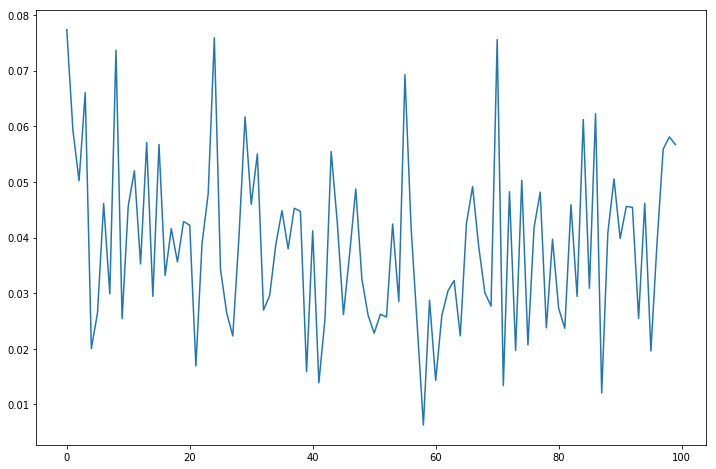

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(loss)
plt.show()

**Interpretation**: The loss presents a strong variability which proves the learning is highly instable. The fully connected framework might be too simplistic to capture representation of spatial contexte of the agent. 

***
***
__Question 8__ Implement the DQN training algorithm using a CNN (for example, 2 convolutional layers and one final fully connected layer).

In [69]:
class DQN_CNN(DQN):
    def __init__(self, *args,lr=0.1,**kwargs):
        super(DQN_CNN, self).__init__(*args,**kwargs)
        
        model = keras.models.Sequential()
        model.add(Conv2D(32, (2, 2), input_shape=(5,5,self.n_state)))
        model.add(Conv2D(64, (2, 2)))
        #model.add(Dropout(0.5))
        #model.add(Conv2D(128, (2, 2), activation='relu'))
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(4,activation='tanh'))
        
        model.compile(sgd(lr=lr, decay=1e-4, momentum=0.0), "mse")
        self.model = model
        print(model.summary())
        
    def learned_act(self, s):
        return np.argmax(self.model.predict(s.reshape((1,5,5,self.n_state))))

In [70]:
T=50
epochs_train=50

env = Environment(grid_size=size, max_time=T, temperature=0.2)
agent = DQN_CNN(size, lr=.1, epsilon = 0.4, memory_size=2000, batch_size = 32)
loss = train(agent,env,epochs_train,prefix='cnn_train')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 4, 4, 32)          288       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 3, 3, 64)          8256      
_________________________________________________________________
flatten_17 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 1024)              590848    
_________________________________________________________________
dropout_29 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 4100      
Total params: 603,492
Trainable params: 603,492
Non-trainable params: 0
_________________________________________________________________
None

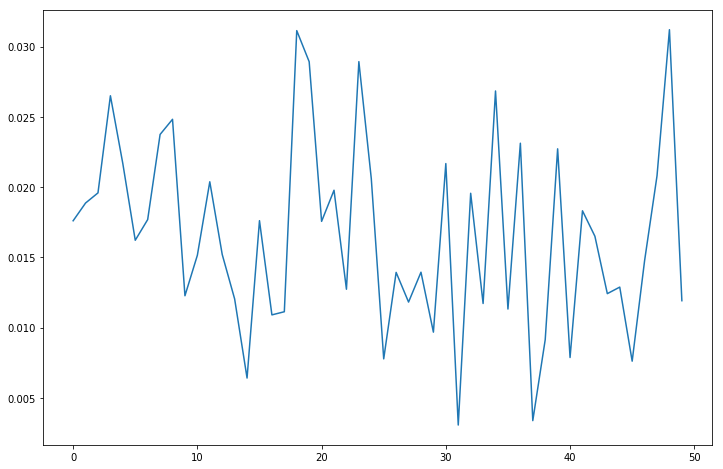

In [71]:
plt.figure(figsize=(12,8))
plt.plot(loss)
plt.show()

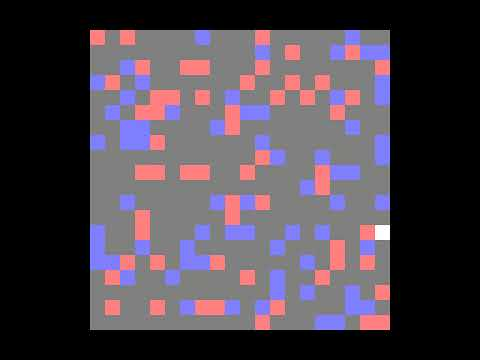

In [72]:
YouTubeVideo('W1mMNJzblZs',width=600, height=600)

**Interpretation**: Again, the learning is highly instable. However, the CNN yealds far better results in terms of behavior/score for the agent. Interestingly, the use of a squashing function for the output of the network gives better results. 

***
***
__Question 9__ Test both algorithms and compare their performances. Which issue(s) do you observe? Observe also different behaviors by changing the temperature.

In [77]:
env = Environment(grid_size=size, max_time=T,temperature=0.2)

agent_cnn = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_cnn.load(name_weights='cnn_trainmodel.h5',name_model='cnn_trainmodel.json')

agent_fc = DQN_FC(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32)
agent_fc.load(name_weights='fc_train10_model.h5',name_model='fc_train10_model.json')

print('Test of the CNN')
test(agent_cnn,env,epochs_test,prefix='cnn_test')
print('Test of the FC')
test(agent_fc,env,epochs_test,prefix='fc_test')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_29 (Conv2D)           (None, 4, 4, 32)          288       
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 3, 3, 64)          8256      
_________________________________________________________________
flatten_21 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 1024)              590848    
_________________________________________________________________
dropout_34 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 4100      
Total params: 603,492
Trainable params: 603,492
Non-trainable params: 0
_________________________________________________________________
None

#### CNN Test

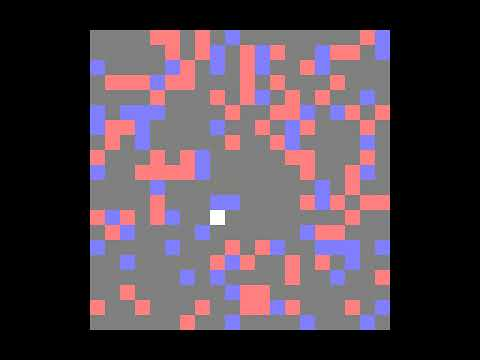

In [78]:
YouTubeVideo('324rJpqwT_g',width=600, height=600)

#### Fully-connected test

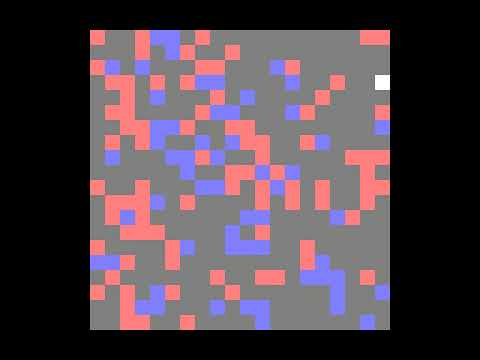

In [66]:
YouTubeVideo('o725EFRdgaw',width=600, height=600)

<font color='blue'>
    
**Interpretation**:

First of all, using a CNN is fully justified by the results that we observed as it allows a better spatial representation by the networks and hence allows better descions.

The second observation to be made is that a higher epsilon ratio helps avoiding the phenomenon of agent oscillating over a position since it introduces more randomness.

The third parameter of importane in the training process is the temperature. Our intuition is that the lower the temperature parameter, the harder it will be for the agent to devise a path that is worth taking. It seems that our experiments verify that assumption. Setting the temperature at 0.8 will result in a better exploration of the map during training and testing, since it can follow a path made by only red cases. Lowering the temperature to 0.2 "freezes" the agent to a part of the map for both of the networks.

Eventually, a big problem of our agent is that it tends to restrict itself to the visit of only a subset of the map. This is due to its acuity grid that surround him but also because revisiting a path is not penalized in our formulation. Hence we should promote variation in the paths taken by the agent to let him eplore the map totally.  

***

The algorithm tends to not explore the map which can be an issue. We propose two ideas in order to encourage exploration:
1. Incorporating a decreasing $\epsilon$-greedy exploration. You can use the method ```set_epsilon```
2. Append via the environment a new state that describes if a cell has been visited or not

***
__Question 10__ Design a new ```train_explore``` function and environment class ```EnvironmentExploring``` to tackle the issue of exploration.



In [60]:
def train_explore(agent,env,epoch,prefix=''):
    # Number of won games
    score = 0
    loss = 0
    
    decay_coeff = 0.99 
    for e in range(epoch):
        # At each epoch, we restart to a fresh game and get the initial state
        state = env.reset()
        # This assumes that the games will terminate
        game_over = False

        win = 0
        lose = 0

        while not game_over:
            # The agent performs an action
            
            action = agent.act(state)
            
            agent.set_epsilon(agent.epsilon*decay_coeff)          
            # Apply an action to the environment, get the next state, the reward
            # and if the games end
            prev_state = state
            state, reward, game_over = env.act(action)

            # Update the counters
            if reward > 0:
                win = round(win + reward,2)
                
            if reward < 0:
                lose = round(lose - reward,2)

            # Apply the reinforcement strategy
            loss = agent.reinforce(prev_state, state, action, reward, game_over)

        # Save as a mp4
        if e % 10 == 0:
            env.draw(prefix+str(e))

        # Update stats
        score += round(win-lose,2)
        

        print("Epoch {:03d}/{:03d} | Loss {:.4f} | Win/lose count {}/{} ({})"
              .format(e, epoch, loss, win, lose, win-lose))
        agent.save(name_weights=prefix+'model.h5',name_model=prefix+'model.json')
        
class EnvironmentExploring(object):
    def __init__(self, grid_size=10, max_time=500, temperature=0.1):
        grid_size = grid_size+4
        self.grid_size = grid_size
        self.max_time = max_time
        self.temperature = temperature

        #board on which one plays
        self.board = np.zeros((grid_size,grid_size))
        self.position = np.zeros((grid_size,grid_size))
        self.malus_position = np.zeros((grid_size,grid_size))

        # coordinate of the rat
        self.x = 0
        self.y = 1

        # self time
        self.t = 0

        self.scale=16

        self.to_draw = np.zeros((max_time+2, grid_size*self.scale, grid_size*self.scale, 3))


    def draw(self,e):
        skvideo.io.vwrite(str(e) + '.mp4', self.to_draw)

    def get_frame(self,t):
        b = np.zeros((self.grid_size,self.grid_size,3))+128
        b[self.board>0,0] = 256
        b[self.board<0,2] = 256
        b[self.x,self.y,:]= 256
        b[-2:,:,:]=0
        b[:,-2:,:]=0
        b[:2,:,:]=0
        b[:,:2,:]=0
        
        b =  cv2.resize(b, None, fx=self.scale, fy=self.scale, interpolation=cv2.INTER_NEAREST)

        self.to_draw[t,:,:,:]=b


    def act(self, action):
        """This function returns the new state, reward and decides if the
        game ends."""
        
        self.get_frame(int(self.t))

        self.position = np.zeros((self.grid_size, self.grid_size))

        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        self.position[:,-2:] = -1

        self.position[self.x, self.y] = 1
        if action == 0:
            if self.x == self.grid_size-3:
                self.x = self.x-1
            else:
                self.x = self.x + 1
        elif action == 1:
            if self.x == 2:
                self.x = self.x+1
            else:
                self.x = self.x-1
        elif action == 2:
            if self.y == self.grid_size - 3:
                self.y = self.y - 1
            else:
                self.y = self.y + 1
        elif action == 3:
            if self.y == 2:
                self.y = self.y + 1
            else:
                self.y = self.y - 1
        else:
            RuntimeError('Error: action not recognized')

        self.t = self.t + 1
        
        reward = 0
        if train: 
            reward = -self.malus_position[self.x, self.y]
        self.malus_position[self.x, self.y] = 0.5
        
        reward += self.board[self.x, self.y]
        
        self.board[self.x, self.y] = 0
        game_over = self.t > self.max_time
        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                        self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)
          
        state = state[self.x-2:self.x+3,self.y-2:self.y+3,:]

        return state, reward, game_over

    def reset(self):
        """This function resets the game and returns the initial state"""

        self.x = np.random.randint(3, self.grid_size-3, size=1)[0]
        self.y = np.random.randint(3, self.grid_size-3, size=1)[0]
        
        bonus = 0.5*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        bonus = bonus.reshape(self.grid_size,self.grid_size)

        malus = -1.0*np.random.binomial(1,self.temperature,size=self.grid_size**2)
        malus = malus.reshape(self.grid_size, self.grid_size)

        self.to_draw = np.zeros((self.max_time+2, self.grid_size*self.scale, self.grid_size*self.scale, 3))

        malus[bonus>0]=0

        self.board = bonus + malus
        self.malus_position = np.zeros((self.grid_size,self.grid_size))
        self.position = np.zeros((self.grid_size, self.grid_size))
        self.position[0:2,:]= -1
        self.position[:,0:2] = -1
        self.position[-2:,:] = -1
        self.position[:,-2:] = -1
        self.board[self.x,self.y] = 0
        self.t = 0

        state = np.concatenate((self.malus_position.reshape(self.grid_size, self.grid_size,1),
                                        self.board.reshape(self.grid_size, self.grid_size,1),
                                self.position.reshape(self.grid_size, self.grid_size,1)),axis=2)

        state = state[self.x - 2:self.x + 3, self.y - 2:self.y + 3, :]
        return state

In [74]:
# Training
T = 100
epochs_train = 50
env = EnvironmentExploring(grid_size=size, max_time=T, temperature=0.4)
agent = DQN_CNN(size, lr=.1, epsilon = 0.1, memory_size=2000, batch_size = 32,n_state=3)
train_explore(agent, env, epochs_train, prefix='cnn_train_explore')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_27 (Conv2D)           (None, 4, 4, 32)          416       
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 3, 3, 64)          8256      
_________________________________________________________________
flatten_20 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 1024)              590848    
_________________________________________________________________
dropout_33 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 4)                 4100      
Total params: 603,620
Trainable params: 603,620
Non-trainable params: 0
_________________________________________________________________
None

#### CNN train explore

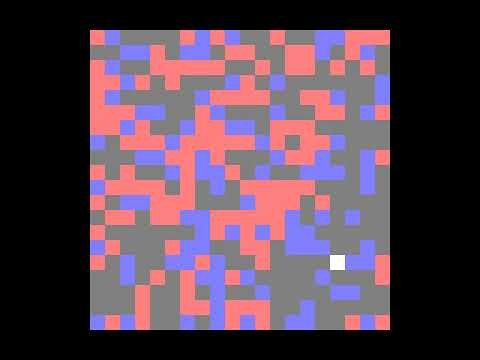

In [75]:
YouTubeVideo('kqvC9E-J-Yk',width=600, height=600)

In [76]:
# Evaluation
test(agent,env,epochs_test,prefix='cnn_test_explore')

Win/lose count 30.0/2.0. Average score (28.0)
Win/lose count 30.5/2.5. Average score (28.0)
Win/lose count 29.0/6.0. Average score (26.333333333333332)
Win/lose count 31.0/2.5. Average score (26.875)
Win/lose count 26.5/5.0. Average score (25.8)
Win/lose count 31.5/3.5. Average score (26.166666666666668)
Win/lose count 29.5/7.5. Average score (25.571428571428573)
Win/lose count 27.5/4.0. Average score (25.3125)
Win/lose count 31.5/3.0. Average score (25.666666666666668)
Win/lose count 26.5/9.0. Average score (24.85)
Final score: 24.85


#### CNN test explore

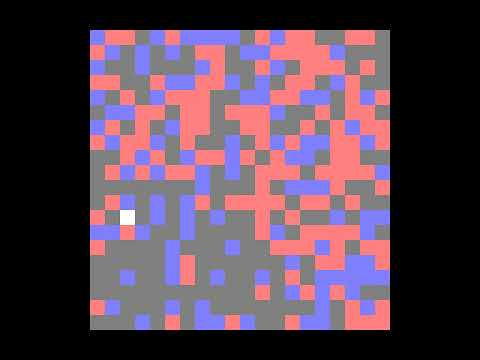

In [64]:
YouTubeVideo('oRuL1pqEI4k',width=600, height=600)

***
***
__BONUS question__ Use the expert DQN from the previous question to generate some winning games. Train a model that mimicks its behavior. Compare the performances.

***